# Linear Regression Solution

Autor: Gallileu Genesis 

Neste notebook foi realizada uma análise de regressão linear em um conjunto de dados. O objetivo principal foi prever o valor alvo ("MedHouseVal") com base em várias características ou recursos contidas no conjunto de dados [California Housing Dataset](https://inria.github.io/scikit-learn-mooc/python_scripts/datasets_california_housing.html). Aqui está uma descrição das principais etapas e objetivos do código:

- **Carregamento de Dados:** O código começa importando as bibliotecas necessárias, configurando algumas opções de visualização e carregando os dados de treinamento e teste a partir de arquivos CSV. Os dados de treinamento têm 37.137 amostras e 8 colunas de recursos, enquanto os dados de teste têm 24.759 amostras e 8 colunas (incluindo a coluna 'id').

- **Preparação dos Dados de Treinamento:** Os dados de treinamento são divididos em duas partes: 'X', que contém todas as colunas, exceto 'id' e 'MedHouseVal', e 'y', que contém apenas a coluna 'MedHouseVal'. Isso cria a divisão entre as características que serão usadas para a previsão e o alvo a ser previsto.

- **Definição de Funções Auxiliares:** O código define várias funções auxiliares, como uma função para calcular o erro quadrático médio (RMSE), uma função para realizar validação cruzada (K-Fold Cross-Validation), uma função para plotar as previsões e outras funções relacionadas à configuração dos modelos.

- **Construção de Modelos de Regressão Linear:** O código cria vários modelos de regressão linear e avalia seu desempenho por meio da validação cruzada. Os modelos incluem:

    1) Regressão Linear Simples (Linear Regression 1).
    2) Regressão Linear com Padronização (Linear Regression 2).
    3) Tratamento de Outliers (Linear Regression 3).
    4) Transformação Logarítmica do Alvo (Linear Regression 4).
    5) Transformação Polinomial de Grau 2 (Linear Regression 5).
    6) Transformação Polinomial de Grau 5 (Linear Regression 6).
    7) Cross-Validation e Previsões Simultâneas (Linear Regression 7).

- **Avaliação dos Modelos e Geração de Previsões:** Os modelos são avaliados em termos de RMSE durante a validação cruzada, e as previsões são geradas para o conjunto de teste usando os modelos. As previsões são então transformadas de volta (no caso dos modelos 4 e 5, que usam logaritmo) e são salvas em arquivos CSV separados para cada modelo. Foram escolhidos para a submissão as previsões dos modelos 4, 5 e 7.

- **Resultados Finais:** Os resultados finais indicam que o "Linear Regression 7" obteve o menor RMSE (1.35543) entre os modelos testados.

In [1]:
import pandas as pd
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:.2f}'.format)

import warnings
warnings.filterwarnings("ignore")

### Banco de dados

O banco de dados de treinamento possui 37137 amostras (entradas/linhas), 8 colunas (features/recursos), além das colunas id e target.

In [2]:
train = pd.read_csv("../Data/train.csv")
print(train.shape)
train.head()

(37137, 10)


,id,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,0,2.39,15.00,3.83,1.11,1280.00,2.49,34.60,-120.12,0.98
1,1,3.72,17.00,6.01,1.05,1504.00,3.81,38.69,-121.22,0.95
2,2,4.78,27.00,6.54,1.10,1061.00,2.46,34.71,-120.45,1.58
3,3,2.41,16.00,3.35,0.97,1255.00,2.09,32.66,-117.09,1.34
4,4,3.75,52.00,4.28,1.07,1793.00,1.60,37.80,-122.41,4.50


O banco de dados de teste possui 24759 amostras (entradas/linhas), 8 colunas (features/recursos), além da coluna id.

In [3]:
test = pd.read_csv("../Data/test.csv")
print(test.shape)
test.head()

(24759, 9)


,id,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,37137,1.71,35.00,4.97,1.10,1318.00,2.84,39.75,-121.85
1,37138,1.39,22.00,4.19,1.10,2296.00,3.18,33.95,-118.29
2,37139,7.72,21.00,7.13,0.96,1535.00,2.89,33.61,-117.81
3,37140,4.68,49.00,4.77,1.05,707.00,1.74,34.17,-118.34
4,37141,3.13,25.00,3.77,1.08,4716.00,2.00,34.17,-118.29


#### Separar os dados para treinamento

In [4]:
X = train.drop(['id', 'MedHouseVal'], axis=1)
y = train['MedHouseVal']

X_test = test.drop(['id'], axis=1)

#### Definir alguns métodos

In [5]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def CrossValidation(X, y, model, n_folds, seed):
    scores =  []
    k = KFold(n_splits=n_folds, random_state=seed, shuffle=True)
    for fold, (train_idx, val_idx) in enumerate(k.split(X, y)):
        print(f'\n--- Fold {fold+1} ---')

        x_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        x_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        predictor = model
        %time predictor.fit(x_train, y_train)

        val_preds = predictor.predict(x_val)
        val_score = rmse(y_val, val_preds)
        scores.append(val_score)

        print(f'--- RMSE: {round(val_score, 6)} ---')

        del x_train, y_train, x_val, y_val, val_preds, val_score, predictor
        gc.collect()

    print('*'*45)
    print(f'Mean RMSE: {round(np.mean(scores), 6)}') 
    
def plot_predictions(predictions, y):
    plt.hist(predictions, label = 'Predictor', bins=50)
    plt.hist(y, label = 'y train', bins=50)

    plt.legend()
    plt.show()

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
import gc

In [7]:
seed = 42
n_folds = 7

### Construir os modelos

**Obs:** Como a EDA mostrou, a distribuição dos recursos são muito semelhantes nos dados de treinamento e teste, o que leva a crer que esse comportamente se replicará nos dados da variável alvo. Portanto, iremos comparar sempre a distribuição das previsões nos dados de teste com a distribuição da variável alvo dos dados de treinamento. 

#### Linear Regression 1: Regressão linear simples.
 

In [8]:
lr_1 = LinearRegression()

CrossValidation(X, y, lr_1, n_folds, seed)


--- Fold 1 ---
CPU times: total: 0 ns
Wall time: 17.7 ms
--- RMSE: 0.752272 ---

--- Fold 2 ---
CPU times: total: 0 ns
Wall time: 14 ms
--- RMSE: 0.734615 ---

--- Fold 3 ---
CPU times: total: 0 ns
Wall time: 9.14 ms
--- RMSE: 2.006205 ---

--- Fold 4 ---
CPU times: total: 31.2 ms
Wall time: 5.04 ms
--- RMSE: 0.714229 ---

--- Fold 5 ---
CPU times: total: 0 ns
Wall time: 9.68 ms
--- RMSE: 0.727589 ---

--- Fold 6 ---
CPU times: total: 0 ns
Wall time: 4.54 ms
--- RMSE: 0.72938 ---

--- Fold 7 ---
CPU times: total: 15.6 ms
Wall time: 15.6 ms
--- RMSE: 0.712326 ---
*********************************************
Mean RMSE: 0.910945


A distribuição das previsões tem média maior do que as dos dados de treinamento.

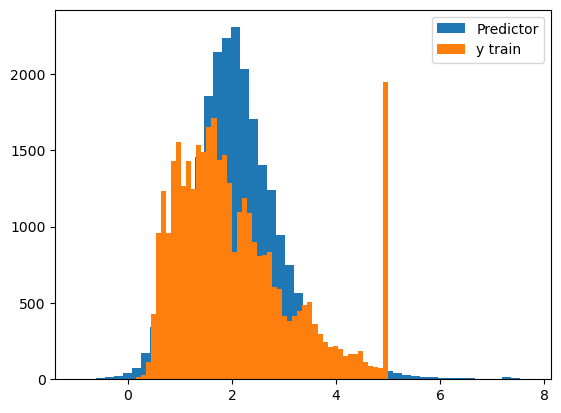

In [9]:
lr_1.fit(X,y)
predictions_1 = lr_1.predict(X_test)
plot_predictions(predictions_1, y)

#### Linear Regression 2: Escala padrão (StandardScaler).

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [11]:
lr_2 = make_pipeline(StandardScaler(), LinearRegression())

CrossValidation(X, y, lr_2, n_folds, seed)


--- Fold 1 ---
CPU times: total: 0 ns
Wall time: 15.6 ms
--- RMSE: 0.752272 ---

--- Fold 2 ---
CPU times: total: 0 ns
Wall time: 15.6 ms
--- RMSE: 0.734615 ---

--- Fold 3 ---
CPU times: total: 31.2 ms
Wall time: 16 ms
--- RMSE: 2.006205 ---

--- Fold 4 ---
CPU times: total: 15.6 ms
Wall time: 17.9 ms
--- RMSE: 0.714229 ---

--- Fold 5 ---
CPU times: total: 0 ns
Wall time: 14.7 ms
--- RMSE: 0.727589 ---

--- Fold 6 ---
CPU times: total: 0 ns
Wall time: 16 ms
--- RMSE: 0.72938 ---

--- Fold 7 ---
CPU times: total: 0 ns
Wall time: 21.1 ms
--- RMSE: 0.712326 ---
*********************************************
Mean RMSE: 0.910945


A padronização dos dados não alterar o desempenho do modelo frente ao anterior.

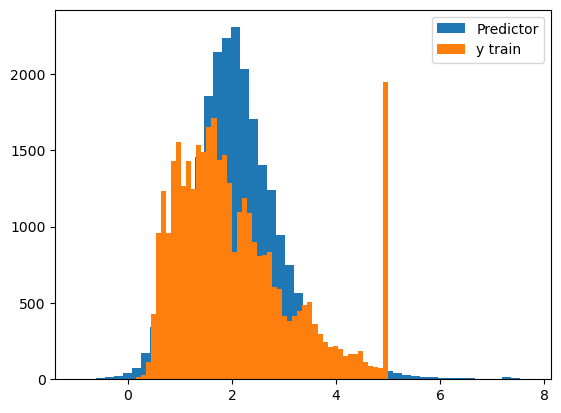

In [12]:
lr_2.fit(X,y)
predictions_2 = lr_2.predict(X_test)
plot_predictions(predictions_2, y)

#### Linear Regression 3: tratamento de outliers

Ao analisar a distribuição dos dados de treinamento, nota-se um valores discrepantes em torno de y=5. Vamos tratar isso simplesmente excluindo essas entradas

In [13]:
X_prep = X[y<5]
y_prep = y[y<5]

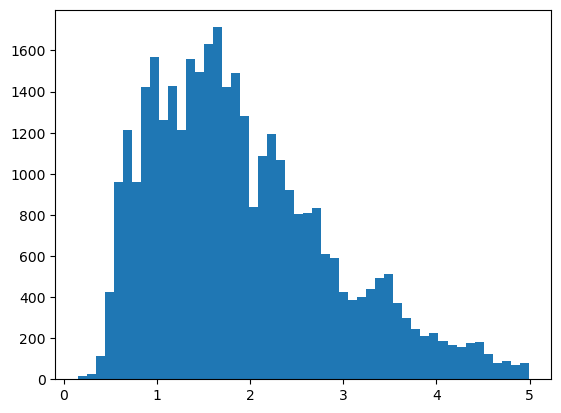

In [14]:
plt.hist(y_prep, bins=50)
plt.show()

In [15]:
lr_3 = make_pipeline(StandardScaler(), LinearRegression())

CrossValidation(X_prep, y_prep, lr_3, n_folds, seed)


--- Fold 1 ---
CPU times: total: 0 ns
Wall time: 14 ms
--- RMSE: 0.628408 ---

--- Fold 2 ---
CPU times: total: 15.6 ms
Wall time: 15.6 ms
--- RMSE: 0.625267 ---

--- Fold 3 ---
CPU times: total: 15.6 ms
Wall time: 7.87 ms
--- RMSE: 1.513658 ---

--- Fold 4 ---
CPU times: total: 0 ns
Wall time: 13.9 ms
--- RMSE: 0.62651 ---

--- Fold 5 ---
CPU times: total: 15.6 ms
Wall time: 16 ms
--- RMSE: 0.627444 ---

--- Fold 6 ---
CPU times: total: 0 ns
Wall time: 24.6 ms
--- RMSE: 0.634432 ---

--- Fold 7 ---
CPU times: total: 0 ns
Wall time: 21.5 ms
--- RMSE: 0.627841 ---
*********************************************
Mean RMSE: 0.754794


O processo de tratamento proposto melhora o desempenho do modelo na validação cruzada, muito embora, visualmente, a distribuição dos dados de previsão permaneça muito semelhante ao dos modelos anteriores. 

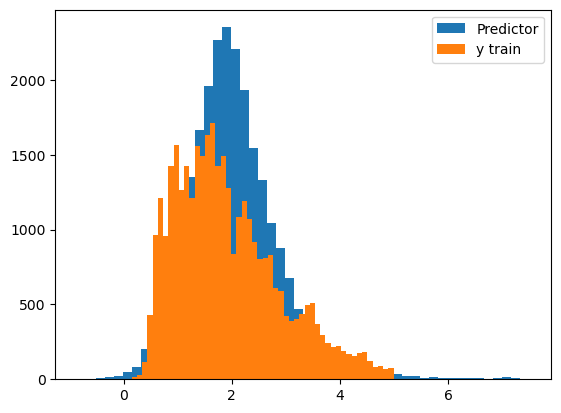

In [16]:
lr_3.fit(X_prep, y_prep)
predictions_3 = lr_3.predict(X_test)
plot_predictions(predictions_3, y_prep)

#### Linear Regression 4: transformação logarítmica do alvo

Mantemos o pipeline anterior e acrescentamos uma transformação logarítmica nos dados da variável de saída.

In [17]:
y_prep_log = np.log(y_prep)

In [18]:
lr_4 = make_pipeline(StandardScaler(), LinearRegression())

CrossValidation(X_prep, y_prep_log, lr_4, n_folds, seed)


--- Fold 1 ---
CPU times: total: 0 ns
Wall time: 15.6 ms
--- RMSE: 0.329351 ---

--- Fold 2 ---
CPU times: total: 15.6 ms
Wall time: 15.6 ms
--- RMSE: 0.332 ---

--- Fold 3 ---
CPU times: total: 0 ns
Wall time: 0 ns
--- RMSE: 0.772235 ---

--- Fold 4 ---
CPU times: total: 0 ns
Wall time: 17.4 ms
--- RMSE: 0.330491 ---

--- Fold 5 ---
CPU times: total: 0 ns
Wall time: 0 ns
--- RMSE: 0.329339 ---

--- Fold 6 ---
CPU times: total: 15.6 ms
Wall time: 15.7 ms
--- RMSE: 0.337944 ---

--- Fold 7 ---
CPU times: total: 0 ns
Wall time: 6.54 ms
--- RMSE: 0.327718 ---
*********************************************
Mean RMSE: 0.394154


A transformação logarítmica dos dados de saída se mostrou muito eficaz, melhorando muito o desempenho do modelo na validação cruzada e produzindo previsões com uma curva bem mais parecida com as dos dados de treinamento. 

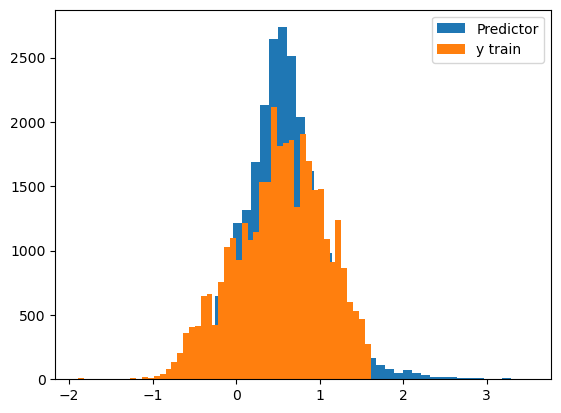

In [19]:
lr_4.fit(X_prep, y_prep_log)
predictions_4 = lr_4.predict(X_test)
plot_predictions(predictions_4, y_prep_log)

#### Linear Regression 5: transformação polinomial de grau 2

Mantemos o pipeline anterior e acrescentamos uma transformação polinomial de grau 2 nos recursos. 

In [20]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_union

In [21]:
lr_5 = make_pipeline(StandardScaler(), 
                     make_union(
                         FunctionTransformer(lambda x: x, validate=True),
                         PolynomialFeatures(degree=2)                         
                     ),
                     LinearRegression())

CrossValidation(X_prep, y_prep_log, lr_5, n_folds, seed)


--- Fold 1 ---
CPU times: total: 62.5 ms
Wall time: 157 ms
--- RMSE: 0.305002 ---

--- Fold 2 ---
CPU times: total: 78.1 ms
Wall time: 141 ms
--- RMSE: 0.311762 ---

--- Fold 3 ---
CPU times: total: 62.5 ms
Wall time: 141 ms
--- RMSE: 18.063236 ---

--- Fold 4 ---
CPU times: total: 93.8 ms
Wall time: 146 ms
--- RMSE: 0.307288 ---

--- Fold 5 ---
CPU times: total: 78.1 ms
Wall time: 142 ms
--- RMSE: 0.310511 ---

--- Fold 6 ---
CPU times: total: 62.5 ms
Wall time: 142 ms
--- RMSE: 0.313576 ---

--- Fold 7 ---
CPU times: total: 62.5 ms
Wall time: 152 ms
--- RMSE: 0.304596 ---
*********************************************
Mean RMSE: 2.845139


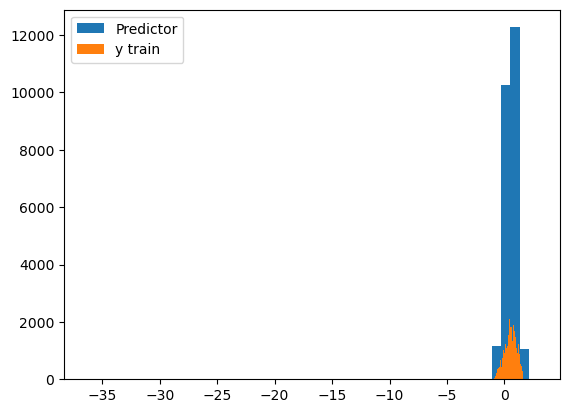

In [22]:
lr_5.fit(X_prep, y_prep_log)
predictions_5 = lr_5.predict(X_test)
plot_predictions(predictions_5, y_prep_log)

#### Linear Regression 6: transformação polinomial de grau 5

In [23]:
lr_6 = make_pipeline(StandardScaler(), 
                     make_union(
                         FunctionTransformer(lambda x: x, validate=True),
                         PolynomialFeatures(degree=5)                         
                     ),
                     LinearRegression())

CrossValidation(X_prep, y_prep_log, lr_6, n_folds, seed)


--- Fold 1 ---
CPU times: total: 7.89 s
Wall time: 8.2 s
--- RMSE: 1.251838 ---

--- Fold 2 ---
CPU times: total: 12.1 s
Wall time: 8.8 s
--- RMSE: 4.169354 ---

--- Fold 3 ---
CPU times: total: 8.83 s
Wall time: 7.9 s
--- RMSE: 64170160.23784 ---

--- Fold 4 ---
CPU times: total: 7.31 s
Wall time: 8.48 s
--- RMSE: 15.57025 ---

--- Fold 5 ---
CPU times: total: 14.2 s
Wall time: 9.58 s
--- RMSE: 41.188752 ---

--- Fold 6 ---
CPU times: total: 8.97 s
Wall time: 8.61 s
--- RMSE: 20.379801 ---

--- Fold 7 ---
CPU times: total: 8.52 s
Wall time: 8.04 s
--- RMSE: 1.476185 ---
*********************************************
Mean RMSE: 9167177.753432


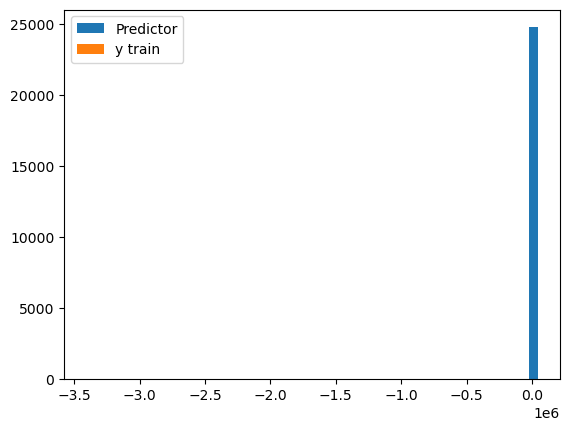

In [24]:
lr_6.fit(X_prep, y_prep_log)
predictions_6 = lr_6.predict(X_test)
plot_predictions(predictions_6, y_prep_log)

As transformação polinomiais não se mostraram eficientes para esse caso.

#### Linear Regression 7: Cross-Validation e previsão simultâneas

Escolhemos o modelo 5 e efetuamos as previsões enquanto realizamos a vlidação cruzada.

In [25]:
def CrossValidation(X, y, X_test, model, n_folds, seed):
    predictions, scores = np.zeros(len(test)), []
    k = KFold(n_splits=n_folds, random_state=seed, shuffle=True)
    
    for fold, (train_idx, val_idx) in enumerate(k.split(X, y)):
        print(f'\n--- Fold {fold+1} ---')

        x_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        x_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        predictor = model
        %time predictor.fit(x_train, y_train)

        val_preds = predictor.predict(x_val)
        val_score = rmse(y_val, val_preds)
        scores.append(val_score)
        
        predictions += predictor.predict(X_test) / n_folds

        print(f'--- RMSE: {round(val_score, 6)} ---')

        del x_train, y_train, x_val, y_val, val_preds, val_score, predictor
        gc.collect()

    print('*'*45)
    print(f'Mean RMSE: {round(np.mean(scores), 6)}') 
    return predictions

In [26]:
predictions_7 = CrossValidation(X_prep, y_prep_log, X_test, lr_5, n_folds, seed)


--- Fold 1 ---
CPU times: total: 62.5 ms
Wall time: 156 ms
--- RMSE: 0.305002 ---

--- Fold 2 ---
CPU times: total: 93.8 ms
Wall time: 131 ms
--- RMSE: 0.311762 ---

--- Fold 3 ---
CPU times: total: 93.8 ms
Wall time: 162 ms
--- RMSE: 18.063236 ---

--- Fold 4 ---
CPU times: total: 62.5 ms
Wall time: 136 ms
--- RMSE: 0.307288 ---

--- Fold 5 ---
CPU times: total: 78.1 ms
Wall time: 140 ms
--- RMSE: 0.310511 ---

--- Fold 6 ---
CPU times: total: 78.1 ms
Wall time: 166 ms
--- RMSE: 0.313576 ---

--- Fold 7 ---
CPU times: total: 78.1 ms
Wall time: 144 ms
--- RMSE: 0.304596 ---
*********************************************
Mean RMSE: 2.845139


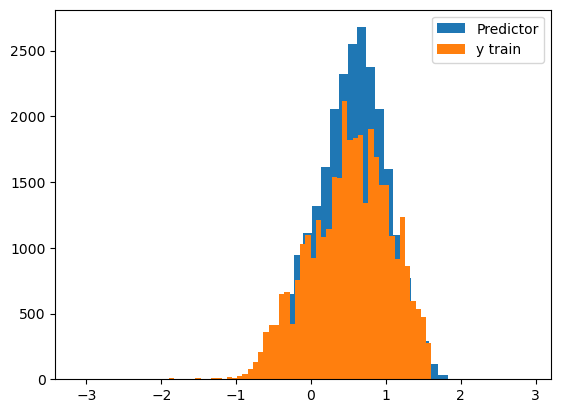

In [27]:
plot_predictions(predictions_7, y_prep_log)

#### Previsões finais: modelos 4, 5 e 7.

In [28]:
df_sub = test.copy()
df_sub['MedHouseVal'] = np.exp(predictions_4)
df_sub[['id','MedHouseVal']].to_csv('LR_Predictions_4.csv', index=False)

In [29]:
df_sub = test.copy()
df_sub['MedHouseVal'] = np.exp(predictions_5)
df_sub[['id','MedHouseVal']].to_csv('LR_Predictions_5.csv', index=False)

In [30]:
df_sub = test.copy()
df_sub['MedHouseVal'] = np.exp(predictions_7)
df_sub[['id','MedHouseVal']].to_csv('LR_Predictions_7.csv', index=False)

#### Scores nos dados de teste:

- **LR_Predictions_7.csv:** 1.35543

- **LR_Predictions_5.csv:** 1.36788

- **LR_Predictions_4.csv:** 1.36788



#### Conclusão:

A estratégia de realizar as previsões juntamente com a validação cruzada obtive melhores scores nos dados de teste. 